# FWI modelo SEG/EAGE

In [19]:
using PyPlot, JLD, SegyIO, JUDI, SlimOptim, Statistics, Random, LinearAlgebra, ImageFiltering, HDF5

In [21]:
n,d,o,m0,m = read(h5open("$(JUDI.JUDI_DATA)/overthrust_model.h5","r"), "n", "d", "o", "m0", "m")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0);

In [22]:
v0 = sqrt.(1f0 ./ m0)
vmin = ones(Float32, model0.n) .* 1.3f0
vmax = ones(Float32, model0.n) .* 6.5f0
vmin[:,1:21] .= v0[:,1:21]   # keep water column fixed
vmax[:,1:21] .= v0[:,1:21];
# Slowness squared [s^2/km^2]
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2);

In [23]:
# Load data
block = segy_read("$(JUDI.JUDI_DATA)/overthrust_shot_records.segy")
d_obs = judiVector(block)

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/geouser/.julia/packages/SegyIO/aQwou/src/read/read_file.jl:36


judiVector{Float32, Matrix{Float32}} with 16 sources


In [24]:
# Set up wavelet
src_geometry = Geometry(block; key="source")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.008f0)  # 8 Hz wavelet
q = judiVector(src_geometry,wavelet)

judiVector{Float32, Matrix{Float32}} with 16 sources


In [25]:
F0 = judiModeling(deepcopy(model0), src_geometry, d_obs.geometry)

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)


In [26]:
# Optimization parameters
niterations = parse(Int, get(ENV, "NITER", "30"))
batchsize = 16
fhistory_SGD = zeros(Float32, niterations)
m0_values = zeros(length(model0.m), niterations);

In [27]:
# Projection operator for bound constraints
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2),model0.n)
ls = BackTracking(order=3, iterations=10, );

In [28]:
# Main loop
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    p = -gradient/norm(gradient, Inf)
    
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

    # linesearch
    function ϕ(α)
        F0.model.m .= proj(model0.m .+ α * p)
        misfit = .5*norm(F0[i]*q[i] - d_obs[i])^2
        @show α, misfit
        return misfit
    end
    step, fval = ls(ϕ, 1f-1, fval, dot(gradient, p))

    # Update model and bound projection
    model0.m .= proj(model0.m .+ step .* p)
    m0_values[:, j] = model0.m
end

FWI iteration no: 1; function value: 521676.0
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 334768.34375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


FWI iteration no: 2; function value: 334871.3
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 980074.5)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.03939895870967427, 580109.9375)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(0.013065328446611381, 171485.109375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 3; function value: 171534.48
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 166549.25)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 4; function value: 166597.7
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 987978.6875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.0357801650489881, 501174.21875)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.010184997029482182, 84524.15625)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


FWI iteration no: 5; function value: 84711.49
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 598373.0)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.02340255658584022, 109325.59375)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s


(0.008795488915517352, 69407.921875)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 6; function value: 69474.43
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 284276.46875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.024020717239680342, 66447.0)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


7; function value: 66513.76


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 987531.375)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.017893707005021672, 95258.5859375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s


(α, misfit) = (0.0064141474065996665, 52833.140625)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


8; function value: 52902.55


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 95234.2734375)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.08 s


(0.03669639304720894, 49127.73046875)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


FWI iteration no: 9; function value: 49209.0
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 808033.625)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.01873064594074571, 118725.734375)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


(0.004667446901220474, 40466.51171875)


Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 10; function value: 40547.562
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 76598.359375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.03589780378050567, 38614.203125)
FWI iteration no: 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s


11; function value: 38702.17


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 957781.0625)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.01386285378678055, 60898.28515625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.0045228660614796455, 32260.740234375)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s


12; function value: 32348.207


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 65794.359375)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.03487253414062962, 31712.728515625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s


FWI iteration no: 13; function value: 31796.324
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 858372.4375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.013758716095077327, 60571.92578125)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


(0.003878099136659843, 26886.599609375)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 14; function value: 26969.982
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 106919.890625)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.02374958504318584, 27761.044921875)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.010793467508856966, 25730.345703125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.03 s


FWI iteration no: 15; function value: 25814.125
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 287692.25)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.09 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.012167676005676586, 26792.84375)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.005417986755961697, 24871.08203125)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


FWI iteration no: 16; function value: 24954.715
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 132420.921875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.0192731024512787, 26199.015625)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(0.008417418684491692, 24205.19921875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s


FWI iteration no: 17; function value: 24281.14
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 265443.375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.012189470288198804, 25292.810546875)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s


(0.005368212423065367, 23485.69140625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


FWI iteration no: 18; function value: 23561.904
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 137449.65625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.018238181444595963, 24886.82421875)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.007866687833459795, 22912.736328125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


FWI iteration no: 19; function value: 22988.838
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 253490.46875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.012123402985370851, 24008.55859375)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.005302683978114636, 22272.65625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 20; function value: 22348.89
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 136921.5)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.01772831195122863, 23685.666015625)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.007591984944682306, 21768.7890625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 21; function value: 21844.898
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 244665.921875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


(α, misfit) = (0.012010594762665472, 22864.09765625)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.0052223958473697546, 21194.421875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 22; function value: 21270.795
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 135582.359375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.01733630864763959, 22612.07421875)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.10 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s


(0.007376325616812048, 20748.607421875)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


FWI iteration no: 23; function value: 20824.863
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 238078.171875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s


(α, misfit) = (0.011867633778042813, 21839.001953125)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


(0.0051330182900320145, 20229.294921875)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 24; function value: 20305.678
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 133801.71875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s


(α, misfit) = (0.017022137003988955, 21648.126953125)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.007199246692482183, 19833.294921875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


FWI iteration no: 25; function value: 19909.66
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 233138.578125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.011704301729905952, 20916.029296875)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.06 s


(0.0050379155352702175, 19360.396484375)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 26; function value: 19436.834
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 131684.15625)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.016770964051618126, 20777.8515625)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


(0.007053546787334692, 19007.576171875)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 27; function value: 19084.06
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 229364.859375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.01152973614860068, 20080.513671875)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(0.004940775823603445, 18574.78125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s


FWI iteration no: 28; function value: 18651.234
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 129425.453125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.016563806405347867, 19989.658203125)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.006929858174350506, 18259.794921875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 29; function value: 18336.27
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 226608.65625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s


(α, misfit) = (0.011345975641708047, 19321.37109375)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(0.004842124502934973, 17861.076171875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


FWI iteration no: 30; function value: 17937.617
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 127043.40625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.01639658723085556, 19254.9375)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(0.006839343779550474, 17580.40625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


In [29]:
fwi = sqrt.(1f0./adjoint(model0.m)).data;
v0 = sqrt.(1f0./M["m0"])';
v = sqrt.(1f0./model.m)'.data;

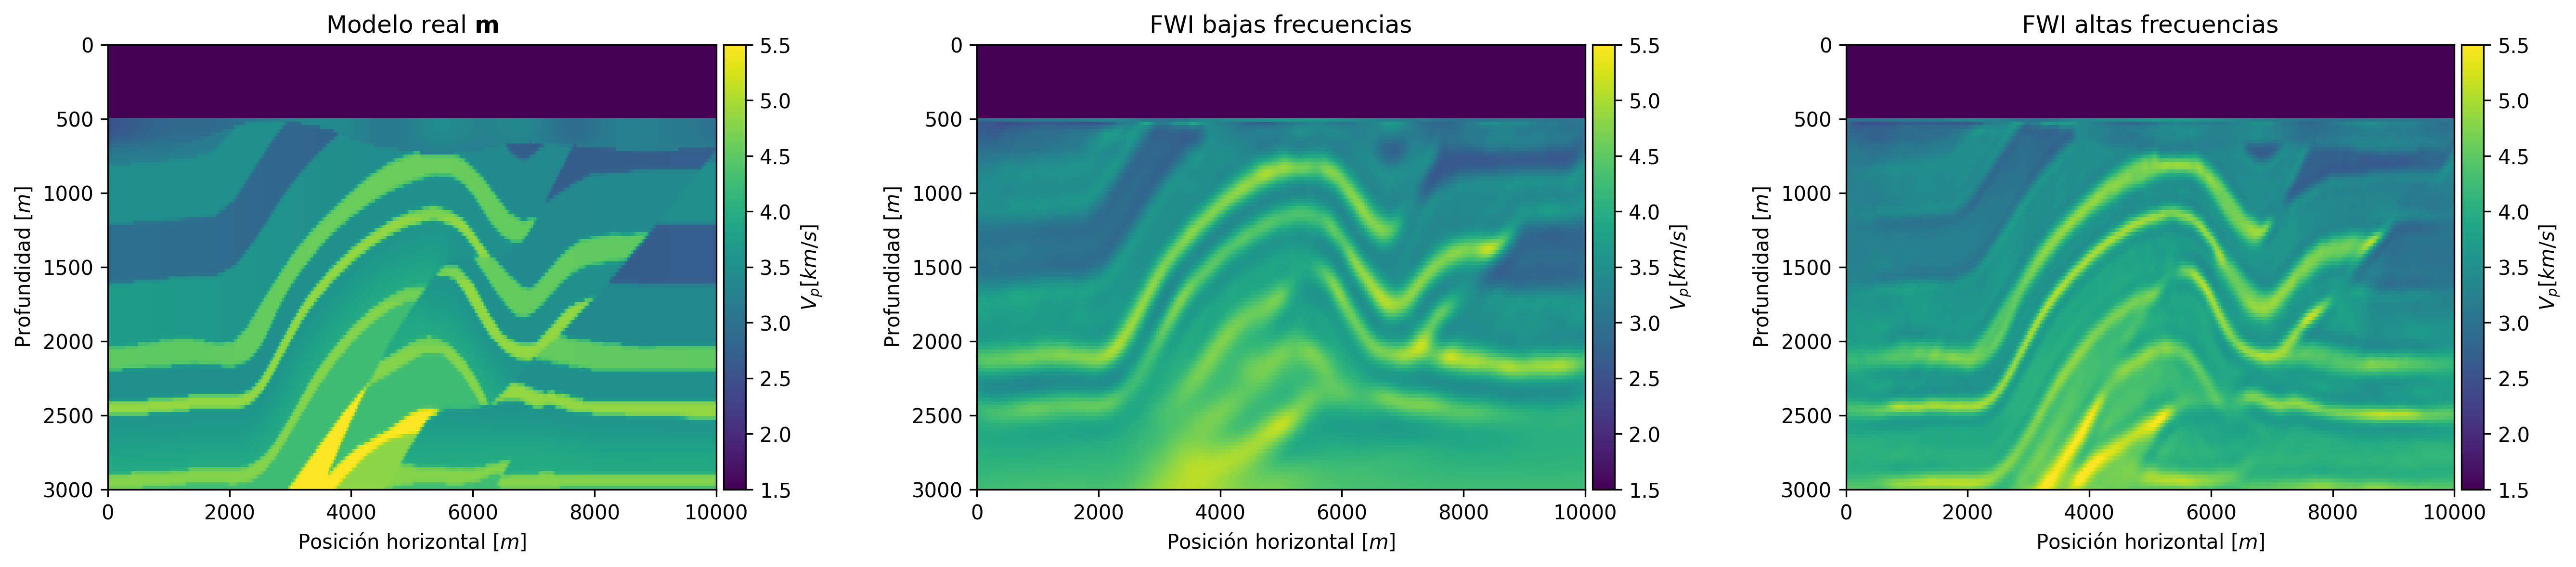

In [35]:
fig=figure(figsize=(22,4), dpi=300);
subplot(131)
im = imshow(v, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo real $\mathbf{m}$")
subplot(132)
im = imshow(v0, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI bajas frecuencias")
subplot(133)
im = imshow(fwi, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI altas frecuencias")
display(fig)

In [36]:
mse = sum((v .- v0).^2) / length(v)
println("El error cuadrático medio del modelo inicial es: ", mse)
mse = sum((v .- fwi).^2) / length(v)
println("El error cuadrático medio de FWI es: ", mse)

El error cuadrático medio del modelo inicial es: 0.053027812
El error cuadrático medio de FWI es: 0.052795872


In [37]:
error_porcentaje_v0 = 100 * sum(abs.(v - v0)) / sum(abs.(v))
error_porcentaje_fwi = 100 * sum(abs.(v - fwi)) / sum(abs.(v))

println("Porcentaje de error (v0): ", error_porcentaje_v0)
println("Porcentaje de error (FWI): ", error_porcentaje_fwi)

Porcentaje de error (v0): 4.485259
Porcentaje de error (FWI): 4.4640307


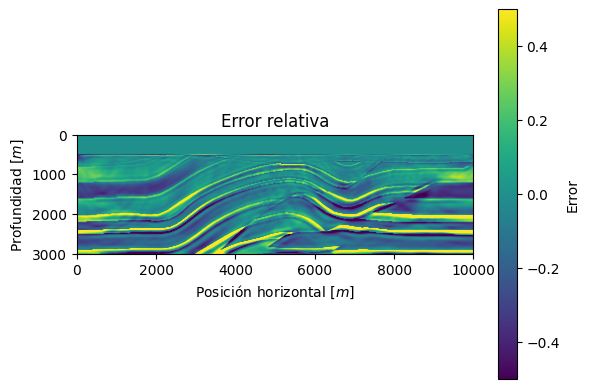

In [38]:
difs = v-fwi
fig=figure() #figsize=(20, 5)
im = imshow(difs, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=-0.5, vmax=0.5)
cb = colorbar(im)
cb[:set_label](label = "Error")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Error relativa")
display(fig)

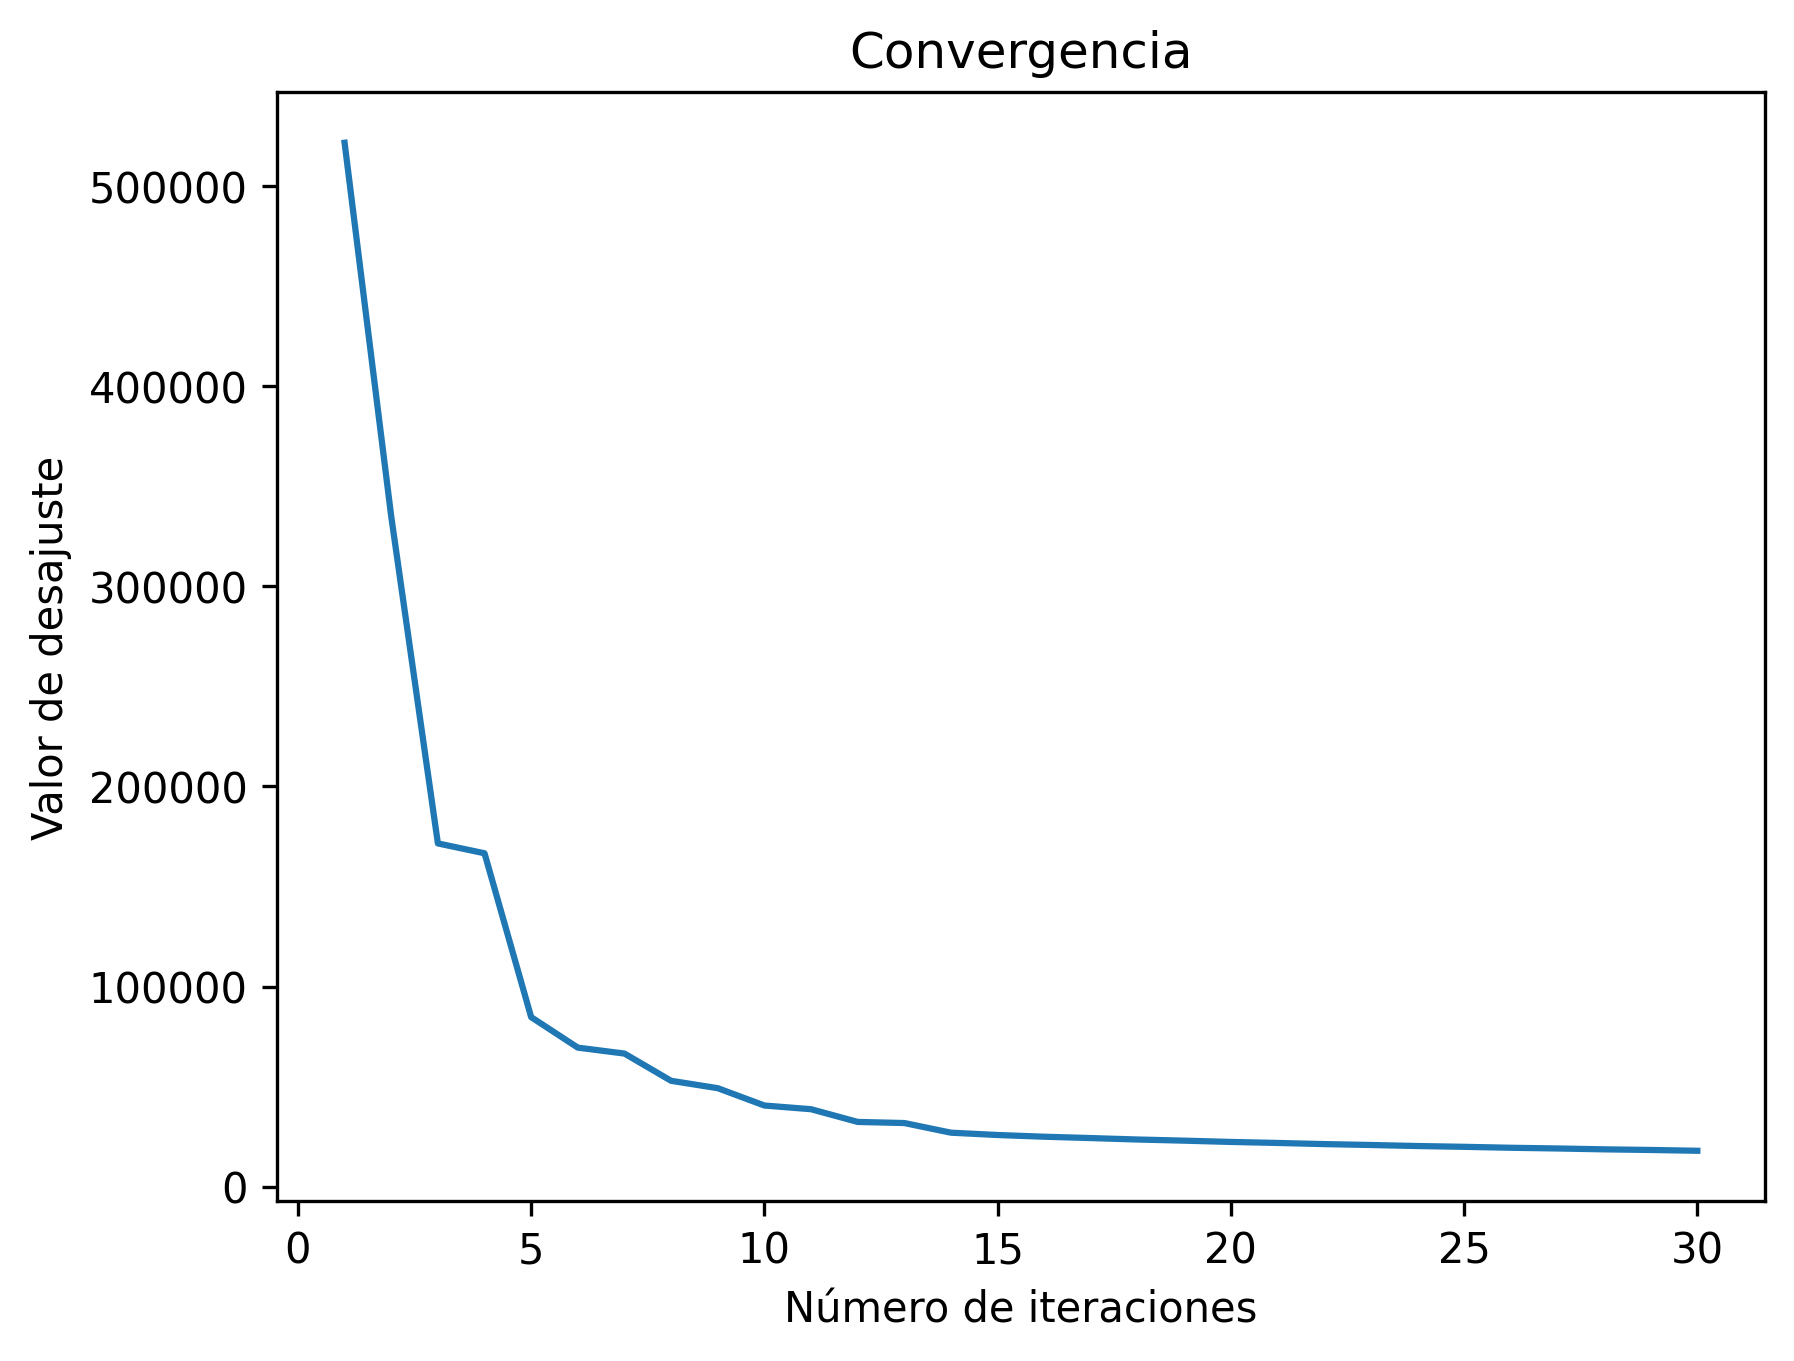

In [39]:
fig=figure(dpi=300) #figsize=(20, 5)
xax = 1:1:30
plot(xax, fhistory_SGD)
xlabel("Número de iteraciones")
ylabel("Valor de desajuste")
title("Convergencia")
display(fig)

In [40]:
save("model_overthrust_fwi_result_high_f.jld", "n", M["n"], "d", M["d"], "o", M["o"], "m", M["m"], "m0", model0.m.data, "dm", dm)